# Image Segmentation using UNet++

## Dependencies

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random
import sys
import cv2

import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 1

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.10.6 (main, Oct  7 2022, 15:17:23) [Clang 12.0.0 ]
Numpy        : 1.22.3
Skimage      : 0.19.3
Tensorflow   : 2.9.1


##Model Hyperparameters

In [4]:
# learning rate
LR = 0.001
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)



In [5]:
xi_true = 'ali'
print(K.flatten(xi_true))

tf.Tensor([b'ali'], shape=(1,), dtype=string)


2023-02-22 10:11:32.103782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Images

In [6]:
image_directory = '/Users/amirshahcheraghian/Downloads/Imagery Dataset test/Train256'
mask_directory = '/Users/amirshahcheraghian/Downloads/Imagery Dataset test/Mask256'

SIZE = 256
num_images = 100

#For Train Dataset
image_names = glob.glob("/Users/amirshahcheraghian/Downloads/Imagery Dataset test/Train256/*.jpg")

image_names.sort()

image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]


image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

#For Mask Dataset
mask_names = glob.glob("/Users/amirshahcheraghian/Downloads/Imagery Dataset test/Mask256/*.jpg")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #Pixel values will be 0 or 1



In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

## Image Augmentation

In [8]:

data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator()
X_datagen_val = ImageDataGenerator()
Y_datagen_val = ImageDataGenerator()

X_datagen.fit(x_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)
test_datagen.fit(x_test, augment=True, seed=13)
X_datagen_val.fit(x_test, augment=True, seed=13)
Y_datagen_val.fit(y_test, augment=True, seed=13)

X_train_augmented = X_datagen.flow(x_train,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train,  batch_size=15, shuffle=True, seed=13)
test_augmented = test_datagen.flow(x_test, shuffle=False, seed=13)
X_train_augmented_val = X_datagen_val.flow(x_test,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_test,  batch_size=15, shuffle=True, seed=13)

train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)

In [9]:
print(train_generator)

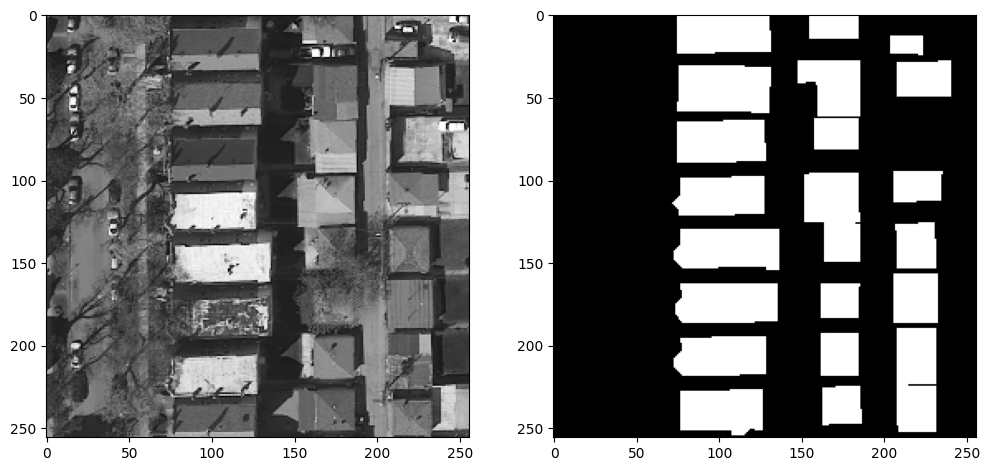

In [10]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(x_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

## Build Model

In [11]:
from keras.layers import Conv2D,Conv2DTranspose,Dropout,MaxPooling2D,concatenate,Input,Lambda

In [12]:
tf.keras.backend.clear_session()
nb_filter = [32,64,128,256,512]
# Build U-Net++ model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(filters = 32, kernel_size=(3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model = Model([inputs], [nestnet_output_4])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=bce_dice_loss)



In [13]:
inputs.shape

TensorShape([None, 256, 256, 1])

In [14]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [15]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=46,
    layer_range=None
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Running The Model

In [16]:
print(x_train.shape)
print(y_train.shape)

(80, 256, 256, 1)
(80, 256, 256, 1)


In [17]:
print(x_train.shape)
print(y_train.shape)

(80, 256, 256, 1)
(80, 256, 256, 1)


In [18]:
x_train_squeeze = np.squeeze(x_train,axis=3)
y_train_squeeze = np.squeeze(y_train,axis=3)

print(x_train_squeeze.shape)
print(y_train_squeeze.shape)

(80, 256, 256)
(80, 256, 256)


In [19]:
x_train_rgb = np.stack((x_train_squeeze,)*3, axis=-1)
y_train_rgb = np.stack((y_train_squeeze,)*3, axis=-1)
print(x_train_rgb.shape)
print(y_train_rgb.shape)

(80, 256, 256, 3)
(80, 256, 256, 3)


In [20]:
checkpoint = ModelCheckpoint('best_model.hdf5' , 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only=True,
                             mode = 'min',
                             save_weights_only=True,
                             save_freq='epoch'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00005)

callbacks_list = [checkpoint, reduce_lr]

# Fit model
history = model.fit(train_generator,  
                    validation_data=val_generator,
                    steps_per_epoch=len(x_train)/(6),
                    validation_steps=10,
                    callbacks=callbacks_list,
                    epochs=2, 
                    verbose=1,)

Epoch 1/2
14/13 [===============================] - ETA: -13s - loss: 0.0871
Epoch 1: val_loss improved from inf to 0.02729, saving model to best_model.hdf5
13/13 [==============================] - 317s 23s/step - loss: 0.0871 - val_loss: 0.0273 - lr: 0.0010
Epoch 2/2
14/13 [===============================] - ETA: -13s - loss: 0.0498
Epoch 2: val_loss improved from 0.02729 to -0.02972, saving model to best_model.hdf5
13/13 [==============================] - 323s 24s/step - loss: 0.0498 - val_loss: -0.0297 - lr: 0.0010


In [21]:
'''
history = model.fit(x_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    shuffle=False)
'''

'\nhistory = model.fit(x_train, y_train, \n                    batch_size = 16, \n                    verbose=1, \n                    epochs=20, \n                    shuffle=False)\n'

##Visualization the Result

3/3 [==============================] - 30s 9s/step


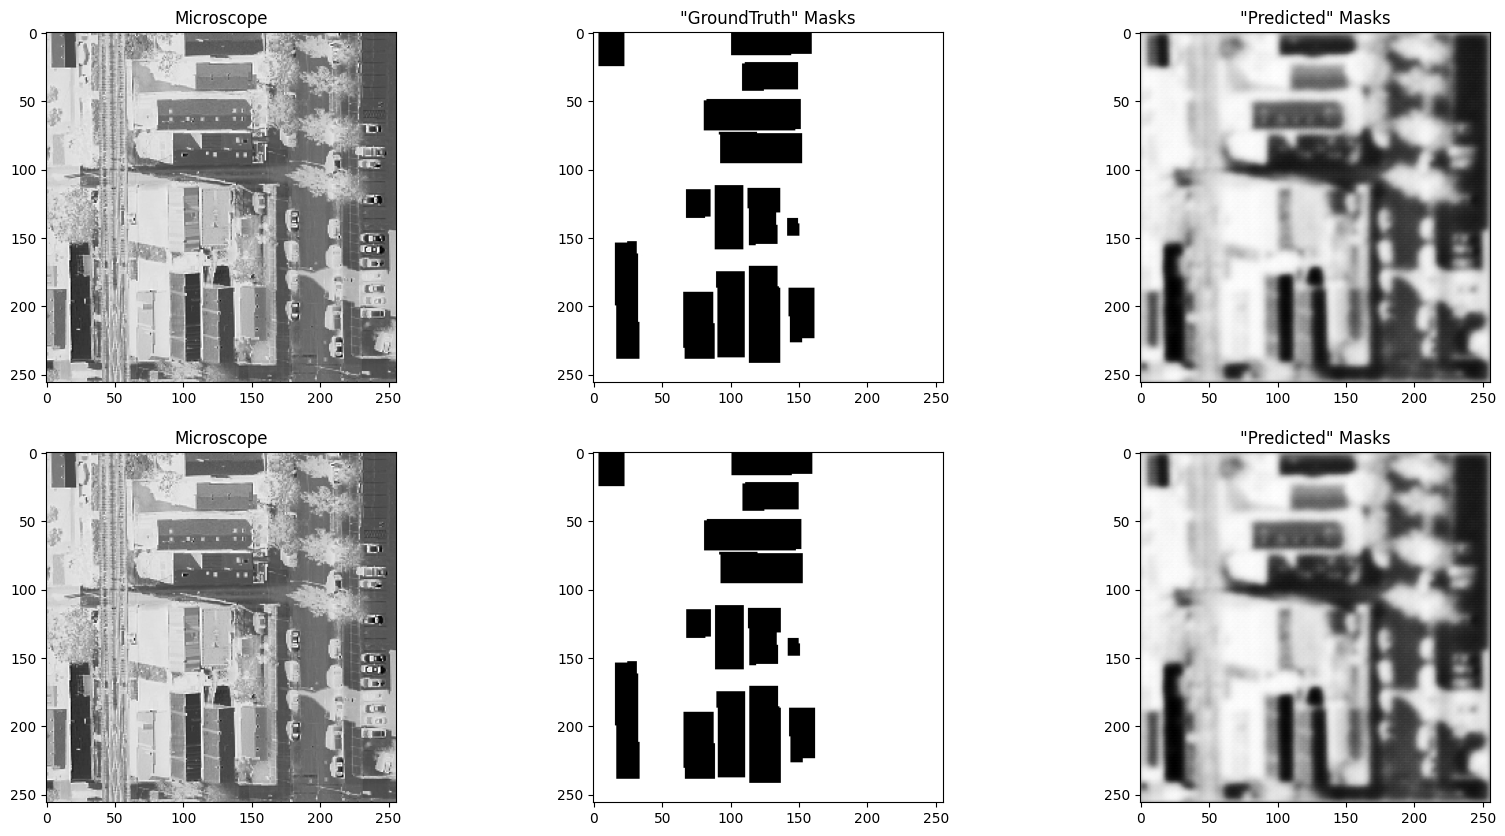

In [28]:
y_predict = model.predict(x_train, verbose=1)
train_ids = image_names_subset
test_ids = mask_names_subset
# Check predict data
f, axarr = plt.subplots(2,3)
f.set_size_inches(20,10)
ix = randint(0, len(train_ids[1]))
axarr[0,0].imshow(x_train[ix],cmap='binary')
axarr[0,0].set_title('Microscope')
axarr[0,1].imshow(np.squeeze(y_train[ix]),cmap='binary')
axarr[0,1].set_title('"GroundTruth" Masks')
axarr[0,2].imshow(np.squeeze(y_predict[ix]),cmap='binary')
axarr[0,2].set_title('"Predicted" Masks')

axarr[1,0].imshow(x_train[ix],cmap='binary')
axarr[1,0].set_title('Microscope')
axarr[1,1].imshow(np.squeeze(y_train[ix]),cmap='binary')
axarr[1,2].set_title('"GroundTruth" Masks')
axarr[1,2].imshow(np.squeeze(y_predict[ix]),cmap='binary')
axarr[1,2].set_title('"Predicted" Masks')

plt.show()

## Predict test labels

1/1 [==============================] - 7s 7s/step
(256, 256, 1)


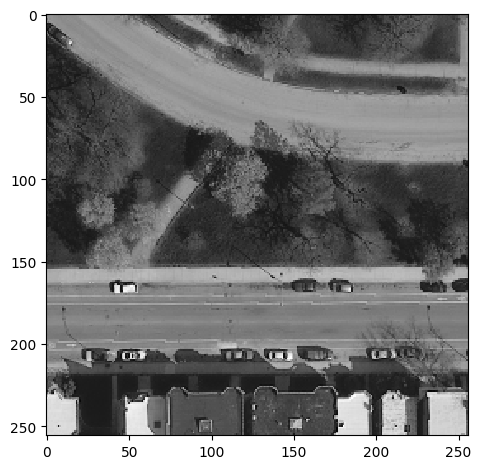

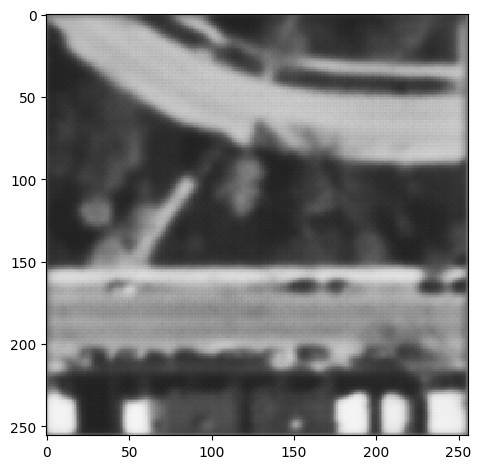

In [30]:
# Use model to predict test labels
Y_hat = model.predict(x_test, verbose=1)
Y_hat.shape
idx = randint(0, 19)
print(x_test[idx].shape)
skimage.io.imshow(x_test[idx])
plt.show();
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show();

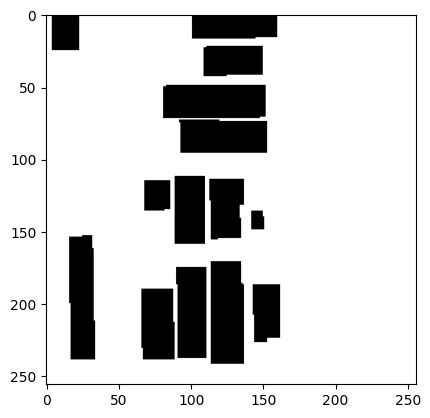

In [32]:
from pylab import *    #This will import the full pylab package, which includes matplotlib and numpy.
imshow(np.squeeze(y_train[ix]),cmap='binary')


# Rooftop Area Computation